<a href="https://colab.research.google.com/github/astrrr/ML-Lab/blob/main/Activity8_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
from sklearn import preprocessing

# 8.1 (a) Load and Prepare Data

In [4]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt
ACC = pd.read_csv('/content/46343_acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('/content/46343_heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('/content/46343_labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [5]:
SleepL

,timedelta,sleep
0,0,-1
1,30,-1
2,60,-1
3,90,-1
4,120,-1
...,...,...
562,16860,0
563,16890,0
564,16920,0
565,16950,0


In [6]:
# Check ‘timedelta’ max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
# Ex
max_list = []
min_list = []
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()

HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()

SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()

max_list.append(ACC_max_date)
max_list.append(HeartR_max_date)
max_list.append(SleepL_max_date)

min_list.append(ACC_min_date)
min_list.append(HeartR_min_date)
min_list.append(SleepL_min_date)

In [7]:
print(f'ACC min//max : {ACC_min_date} // {ACC_max_date}')
print(f'HeartR min//max : {HeartR_min_date} // {HeartR_max_date}')
print(f'SleepL min//max : {SleepL_min_date} // {SleepL_max_date}')

ACC min//max : -124489.16105 // 15043.4923749
HeartR min//max : -556410.36066 // 16980.47229
SleepL min//max : 0 // 16980


In [8]:
# หา start_timedelta, end_timedelta
start_timedelta = np.array(min_list).max()
end_timedelta = np.array(max_list).min()

In [9]:
print('start_timedelta : ',start_timedelta)
print('end_timedelta   : ',end_timedelta)

start_timedelta :  0.0
end_timedelta   :  15043.4923749


In [10]:
# select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน)

ACC_new = ACC[(ACC['timedelta'] > start_timedelta) &(ACC['timedelta'] < end_timedelta)]
HeartR_new = HeartR[(HeartR['timedelta'] > start_timedelta) &(HeartR['timedelta'] < end_timedelta)]
SleepL_new = SleepL[(SleepL['timedelta'] > start_timedelta) &(SleepL['timedelta'] < end_timedelta)]

In [11]:
ACC_new

,timedelta,accX,accY,accZ
98777,0.000721,-0.234650,0.905975,0.362747
98778,0.017162,-0.231232,0.893265,0.371613
98779,0.037183,-0.227814,0.915848,0.369049
98780,0.057108,-0.240524,0.919159,0.352890
98781,0.076929,-0.240448,0.889175,0.350143
...,...,...,...,...
851877,15043.392519,-0.360016,-0.212280,0.906097
851878,15043.412454,-0.360519,-0.212753,0.908050
851879,15043.432433,-0.357559,-0.214233,0.908066
851880,15043.452436,-0.355606,-0.213242,0.908569


In [12]:
HeartR_new

,timedelta,heartrate
1576,8.47840,97
1577,13.47840,95
1578,18.47840,96
1579,19.47840,95
1580,24.47840,95
...,...,...
4496,15022.46938,77
4497,15027.46938,77
4498,15032.46938,77
4499,15037.46938,77


In [13]:
SleepL_new

,timedelta,sleep
1,30,-1
2,60,-1
3,90,-1
4,120,-1
5,150,-1
...,...,...
497,14910,2
498,14940,2
499,14970,2
500,15000,2


# 8.1 (b) Load and Prepare Data (ACC)

In [14]:
from pandas.tseries.offsets import *
# ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
# Convert to datetime and round to second,
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], unit='s').round('1s'))
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'], unit='s').round('1s'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [15]:
ACC_new

,timedelta,accX,accY,accZ
98777,0 days 00:00:00,-0.234650,0.905975,0.362747
98778,0 days 00:00:00,-0.231232,0.893265,0.371613
98779,0 days 00:00:00,-0.227814,0.915848,0.369049
98780,0 days 00:00:00,-0.240524,0.919159,0.352890
98781,0 days 00:00:00,-0.240448,0.889175,0.350143
...,...,...,...,...
851877,0 days 04:10:43,-0.360016,-0.212280,0.906097
851878,0 days 04:10:43,-0.360519,-0.212753,0.908050
851879,0 days 04:10:43,-0.357559,-0.214233,0.908066
851880,0 days 04:10:43,-0.355606,-0.213242,0.908569


In [16]:
HeartR_new

,timedelta,heartrate
1576,0 days 00:00:08,97
1577,0 days 00:00:13,95
1578,0 days 00:00:18,96
1579,0 days 00:00:19,95
1580,0 days 00:00:24,95
...,...,...
4496,0 days 04:10:22,77
4497,0 days 04:10:27,77
4498,0 days 04:10:32,77
4499,0 days 04:10:37,77


In [17]:
SleepL_new

,timedelta,sleep
1,0 days 00:00:30,-1
2,0 days 00:01:00,-1
3,0 days 00:01:30,-1
4,0 days 00:02:00,-1
5,0 days 00:02:30,-1
...,...,...
497,0 days 04:08:30,2
498,0 days 04:09:00,2
499,0 days 04:09:30,2
500,0 days 04:10:00,2


In [18]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()

In [19]:
df_acc_Z

,timedelta,accZ
0,0 days 00:00:00,0.367591
1,0 days 00:00:01,0.415446
2,0 days 00:00:02,0.387026
3,0 days 00:00:03,0.347812
4,0 days 00:00:04,0.321502
...,...,...
15039,0 days 04:10:39,0.906136
15040,0 days 04:10:40,0.907540
15041,0 days 04:10:41,0.907021
15042,0 days 04:10:42,0.906196


In [20]:
# acc_X, acc_Y, acc_Z
acc_xyz = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1, join="inner")

In [21]:
result = pd.merge(df_acc_X, df_acc_Y, on=["timedelta"])

In [22]:
result = pd.merge(result, df_acc_Z, on=["timedelta"])

In [23]:
result

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
15039,0 days 04:10:39,-0.357004,-0.213989,0.906136
15040,0 days 04:10:40,-0.354852,-0.212050,0.907540
15041,0 days 04:10:41,-0.355704,-0.212626,0.907021
15042,0 days 04:10:42,-0.357162,-0.214460,0.906196


In [24]:
acc_xyz = result

In [25]:
acc_xyz

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
15039,0 days 04:10:39,-0.357004,-0.213989,0.906136
15040,0 days 04:10:40,-0.354852,-0.212050,0.907540
15041,0 days 04:10:41,-0.355704,-0.212626,0.907021
15042,0 days 04:10:42,-0.357162,-0.214460,0.906196


# before / after

In [26]:
print('--------------------Before convert date time and round and AVG to 1s-------------')
print(ACC[0:5])
print('--------------------After convert date time and round and AVG to 1s-------------')
print(acc_xyz[0:5])

--------------------Before convert date time and round and AVG to 1s-------------
       timedelta      accX      accY      accZ
0 -124489.161050  0.017487 -0.586700 -0.805771
1 -124489.116395  0.018982 -0.589676 -0.809158
2 -124489.115548  0.020966 -0.580887 -0.815048
3 -124489.114691  0.019485 -0.580872 -0.813583
4 -124489.097700  0.016998 -0.587204 -0.806259
--------------------After convert date time and round and AVG to 1s-------------
        timedelta      accX      accY      accZ
0 0 days 00:00:00 -0.243203  0.895372  0.367591
1 0 days 00:00:01 -0.240757  0.873826  0.415446
2 0 days 00:00:02 -0.244620  0.883943  0.387026
3 0 days 00:00:03 -0.248036  0.902427  0.347812
4 0 days 00:00:04 -0.241778  0.912946  0.321502


# 8.1 (c) Load and Prepare Data (Heart rate)

In [27]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()

In [28]:
HeartR_new2

,heartrate
timedelta,
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,97.0
0 days 00:00:12,97.0
...,...
0 days 04:10:38,77.0
0 days 04:10:39,77.0
0 days 04:10:40,77.0


# 8.1 (d) Load and Prepare Data (Sleep Label)

In [29]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()

In [30]:
SleepL_new2

,sleep
timedelta,
0 days 00:00:30,-1.0
0 days 00:00:31,-1.0
0 days 00:00:32,-1.0
0 days 00:00:33,-1.0
0 days 00:00:34,-1.0
...,...
0 days 04:10:26,2.0
0 days 04:10:27,2.0
0 days 04:10:28,2.0


# 8.1 (e) Merge Data and Standardized data



In [31]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(acc_xyz, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on = 'timedelta')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15044 entries, 0 to 15043
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   timedelta  15044 non-null  timedelta64[ns]
 1   accX       15044 non-null  float64        
 2   accY       15044 non-null  float64        
 3   accZ       15044 non-null  float64        
 4   heartrate  15036 non-null  float64        
 5   sleep      15014 non-null  float64        
dtypes: float64(5), timedelta64[ns](1)
memory usage: 822.7 KB


In [33]:
# Fill NA
# Heart rate
median = df['heartrate'].median()
df["heartrate"].fillna(median, inplace = True)

In [34]:
# Sleep Label
# Fillna() # with 0
df["sleep"].fillna(0, inplace = True)

In [35]:
df

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.243203,0.895372,0.367591,82.0,0.0
1,0 days 00:00:01,-0.240757,0.873826,0.415446,82.0,0.0
2,0 days 00:00:02,-0.244620,0.883943,0.387026,82.0,0.0
3,0 days 00:00:03,-0.248036,0.902427,0.347812,82.0,0.0
4,0 days 00:00:04,-0.241778,0.912946,0.321502,82.0,0.0
...,...,...,...,...,...,...
15039,0 days 04:10:39,-0.357004,-0.213989,0.906136,77.0,2.0
15040,0 days 04:10:40,-0.354852,-0.212050,0.907540,77.0,2.0
15041,0 days 04:10:41,-0.355704,-0.212626,0.907021,77.0,2.0
15042,0 days 04:10:42,-0.357162,-0.214460,0.906196,77.0,2.0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15044 entries, 0 to 15043
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   timedelta  15044 non-null  timedelta64[ns]
 1   accX       15044 non-null  float64        
 2   accY       15044 non-null  float64        
 3   accZ       15044 non-null  float64        
 4   heartrate  15044 non-null  float64        
 5   sleep      15044 non-null  float64        
dtypes: float64(5), timedelta64[ns](1)
memory usage: 822.7 KB


In [37]:
# Drop column
df.drop(df.columns[0], axis =1 ,inplace=True)

In [38]:
df

,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,82.0,0.0
1,-0.240757,0.873826,0.415446,82.0,0.0
2,-0.244620,0.883943,0.387026,82.0,0.0
3,-0.248036,0.902427,0.347812,82.0,0.0
4,-0.241778,0.912946,0.321502,82.0,0.0
...,...,...,...,...,...
15039,-0.357004,-0.213989,0.906136,77.0,2.0
15040,-0.354852,-0.212050,0.907540,77.0,2.0
15041,-0.355704,-0.212626,0.907021,77.0,2.0
15042,-0.357162,-0.214460,0.906196,77.0,2.0


In [39]:
# Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
df_feature = df[feature_columns]  # standardized data of df_feature
df_label = df[label_columns]

In [40]:
df_feature

,accX,accY,accZ,heartrate
0,-0.243203,0.895372,0.367591,82.0
1,-0.240757,0.873826,0.415446,82.0
2,-0.244620,0.883943,0.387026,82.0
3,-0.248036,0.902427,0.347812,82.0
4,-0.241778,0.912946,0.321502,82.0
...,...,...,...,...
15039,-0.357004,-0.213989,0.906136,77.0
15040,-0.354852,-0.212050,0.907540,77.0
15041,-0.355704,-0.212626,0.907021,77.0
15042,-0.357162,-0.214460,0.906196,77.0


In [41]:
df_label

,sleep
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
15039,2.0
15040,2.0
15041,2.0
15042,2.0


In [42]:
# standardize data
X_scaler = preprocessing.StandardScaler()
X_tranfrom = X_scaler.fit_transform(df_feature)

In [43]:
X_tranfrom

array([[-0.62515644,  3.92672811,  0.76522455,  0.19734803],
       [-0.61921018,  3.84190718,  0.82308854,  0.19734803],
       [-0.62860071,  3.88173709,  0.78872408,  0.19734803],
       ...,
       [-0.89861833, -0.4352966 ,  1.41747485, -0.57705433],
       [-0.90216193, -0.44251962,  1.41647668, -0.57705433],
       [-0.90163429, -0.44039859,  1.41659696, -0.57705433]])

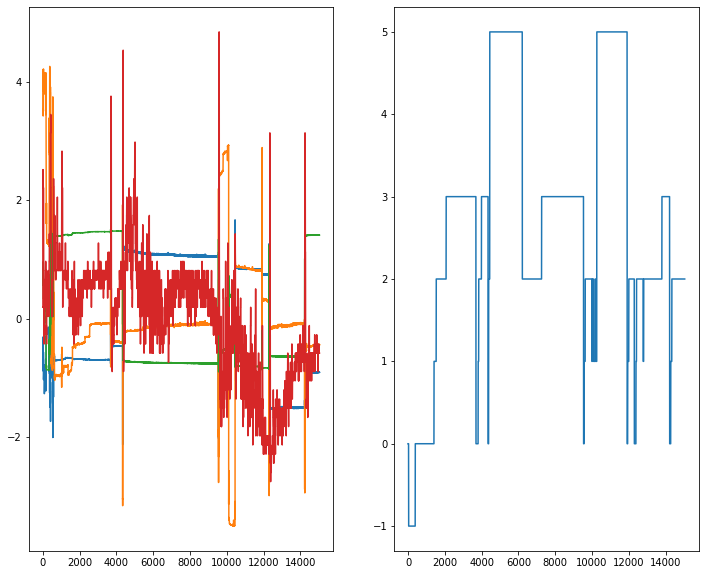

In [44]:
# Visualize signals
fig = plt.figure(figsize=(12,10))

fig.add_subplot(121)
plt.plot(X_tranfrom)

fig.add_subplot(122)
plt.plot(df_label)

plt.show()

# 8.2 MODEL PREPARATION

# 8.2 (a) SVM Model Training and Testing

In [45]:
Y = df_label

In [47]:
Y

,sleep
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
15039,2.0
15040,2.0
15041,2.0
15042,2.0


In [48]:
# Train Test Split
Rseed = 42
x_train_set, x_test, y_train_set, y_test = train_test_split(X_tranfrom, Y, test_size = 0.3, random_state = Rseed)

In [49]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train_set, y_train_set, test_size = 0.3, random_state = Rseed)

In [50]:
# Model Traing Parameter
#Create SVC model
c_val = 100  
gmm =0.1
d = 2

In [51]:
# Model initialize
svc_lin = SVC(kernel='linear', C=c_val)
svc_rbf = SVC(kernel='rbf', C=c_val, gamma=gmm)
svc_poly = SVC(kernel='poly', C=c_val, degree = d)

In [53]:
# Model Training
svc_lin = svc_lin.fit(x_train, y_train)
svc_rbf = svc_rbf.fit(x_train, y_train)
svc_poly = svc_poly.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
# Model Testing (Predict)
svc_lin_pred = svc_lin.predict(x_test)
svc_rbf_pred = svc_rbf.predict(x_test)
svc_poly_pred = svc_poly.predict(x_test)

# 8.2 (b) SVM Prediction Report

In [60]:
# Model Confusion Matrix of SVC_rbf, SVC_poly
print('Confusion Matrix of RBF : ')
print(confusion_matrix(y_test,svc_rbf_pred))
print('///////////////////////////////////')
print('///////////////////////////////////')
print('Confusion Matrix of Poly : ')
print(confusion_matrix(y_test,svc_poly_pred))

Confusion Matrix of RBF : 
[[ 104    4    0    0    0    0]
 [   6  335    3   38   25    8]
 [   0   30   62   81    1   10]
 [   0   20   14 1134   96   32]
 [   0    8    0   53 1412    0]
 [   2    1    1  148    0  886]]
///////////////////////////////////
///////////////////////////////////
Confusion Matrix of Poly : 
[[ 101    6    0    1    0    0]
 [   8  325    1   43   33    5]
 [   3   42   26   97    6   10]
 [   0   30    8 1029  195   34]
 [   0   10    0   76 1387    0]
 [   0    0    2  165    0  871]]


In [62]:
# Model Classification Report of SVC_rbf, SVC_poly
print('Calassification report of RBF : ')
print(classification_report(y_test,svc_rbf_pred))
print('/////////////////////////////////////////////////////////')
print('/////////////////////////////////////////////////////////')
print('Calassification report of Poly : ')
print(classification_report(y_test,svc_poly_pred))

Calassification report of RBF : 
              precision    recall  f1-score   support

        -1.0       0.93      0.96      0.95       108
         0.0       0.84      0.81      0.82       415
         1.0       0.78      0.34      0.47       184
         2.0       0.78      0.88      0.82      1296
         3.0       0.92      0.96      0.94      1473
         5.0       0.95      0.85      0.90      1038

    accuracy                           0.87      4514
   macro avg       0.87      0.80      0.82      4514
weighted avg       0.87      0.87      0.87      4514

/////////////////////////////////////////////////////////
/////////////////////////////////////////////////////////
Calassification report of Poly : 
              precision    recall  f1-score   support

        -1.0       0.90      0.94      0.92       108
         0.0       0.79      0.78      0.79       415
         1.0       0.70      0.14      0.24       184
         2.0       0.73      0.79      0.76      1296
   

# 8.3 HYPERPARAMETER TUNING (GRIDSEARCHCV()) SVM

In [72]:
# Create Model Parameter Dictionary for SVC
kernel = ['linear', 'rbf', 'poly']
C_list = [0.1, 1.0, 10.0, 100.0, 200.0]
Gamma_list = [0.01, 0.1, 1.0, 10]
d_list = [2, 3]

params_SVR = dict(kernel = kernel, C = C_list, gamma = Gamma_list, degree = d_list )

In [75]:
# Perform GridsearchCV() for each classification model
# grid = GridSearchCV( model, n_jobs, , verbose, scoring = 'accuracy', cv = 2, param_grid)
# grid_result = grid.fit(x_train, y_train)

k = 2


grid = GridSearchCV( estimator=SVC(), n_jobs = 3,

                      verbose = 2,
                      cv = k,
                      scoring = 'accuracy',
                      param_grid = params_SVR )

grid_result = grid.fit(x_train, y_train)


Fitting 2 folds for each of 120 candidates, totalling 240 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [76]:
!pip install line-bot-sdk

     |████████████████████████████████| 87 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 14.8 MB/s 
     |████████████████████████████████| 144 kB 50.0 MB/s 
     |████████████████████████████████| 271 kB 53.1 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 


In [77]:
from linebot import LineBotApi
from linebot.models import TextSendMessage
from linebot.exceptions import LineBotApiError

line_bot_api = LineBotApi('ZRjyjNwSVRqlhznKRP7Ls7IUV8pgmyUxdGnBGMfEf6teuPM+qtWQg8BuOwnsUUAEC6h7RRTRssYO4Gt2NguYF7etzhJiU0JBWZdfdAbIkFxHalnIumMN/8710BIrVnn3Xj7NxjcHkbq8I8b20s36VQdB04t89/1O/w1cDnyilFU=')

In [78]:
try:
    line_bot_api.push_message('Ua8dbc2f97b9014c36aac262f1a8bd285', TextSendMessage(text='Train เสร็จแล้ว !!'))
except LineBotApiError as e:
    # error handle
    ...

In [83]:
# Show best search results
print('Best params: ',grid_result.best_params_)
print('Best score : ',grid_result.best_score_)

Best params:  {'C': 200.0, 'degree': 2, 'gamma': 10, 'kernel': 'rbf'}
Best score :  0.9280965566288815


In [96]:
# Show and Display Mean, std, params
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

lin_mean_list = []
lin_std_list = []
lin_params_list = []
rbf_mean_list = []
rbf_std_list = []
rbf_params_list = []
poly_mean_list = []
poly_std_list = []
poly_params_list = []

for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))
  if param['kernel'] == 'linear':
    lin_mean_list.append(mean)
    lin_std_list.append(stdev)
    lin_params_list.append(str(param))
  elif param['kernel'] == 'rbf':
    rbf_mean_list.append(mean)
    rbf_std_list.append(stdev)
    rbf_params_list.append(str(param))
  elif param['kernel'] == 'poly':
    poly_mean_list.append(mean)
    poly_std_list.append(stdev)
    poly_params_list.append(str(param))

0.626645 (0.002934) with: {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'linear'}
0.517840 (0.000879) with: {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
0.319631 (0.000043) with: {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
0.626645 (0.002934) with: {'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'}
0.676027 (0.001401) with: {'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
0.514312 (0.004407) with: {'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.626645 (0.002934) with: {'C': 0.1, 'degree': 2, 'gamma': 1.0, 'kernel': 'linear'}
0.763533 (0.001524) with: {'C': 0.1, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
0.723103 (0.007499) with: {'C': 0.1, 'degree': 2, 'gamma': 1.0, 'kernel': 'poly'}
0.626645 (0.002934) with: {'C': 0.1, 'degree': 2, 'gamma': 10, 'kernel': 'linear'}
0.775471 (0.003151) with: {'C': 0.1, 'degree': 2, 'gamma': 10, 'kernel': 'rbf'}
0.816036 (0.001060) with: {'C': 0.1, 'degree': 2, 'gamma': 10, 'kernel': 'poly'}
0.626645 (0.

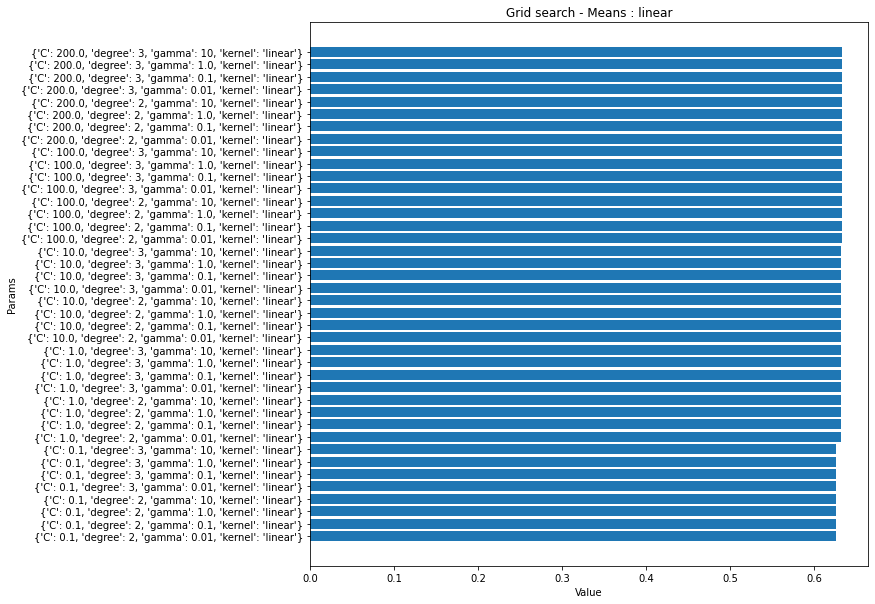

In [97]:
# plot bar
# linear
fig = plt.figure(figsize=(10,10))
plt.barh(lin_params_list, lin_mean_list)
plt.title('Grid search - Means : linear') 
plt.ylabel('Params')
plt.xlabel('Value')
plt.show()

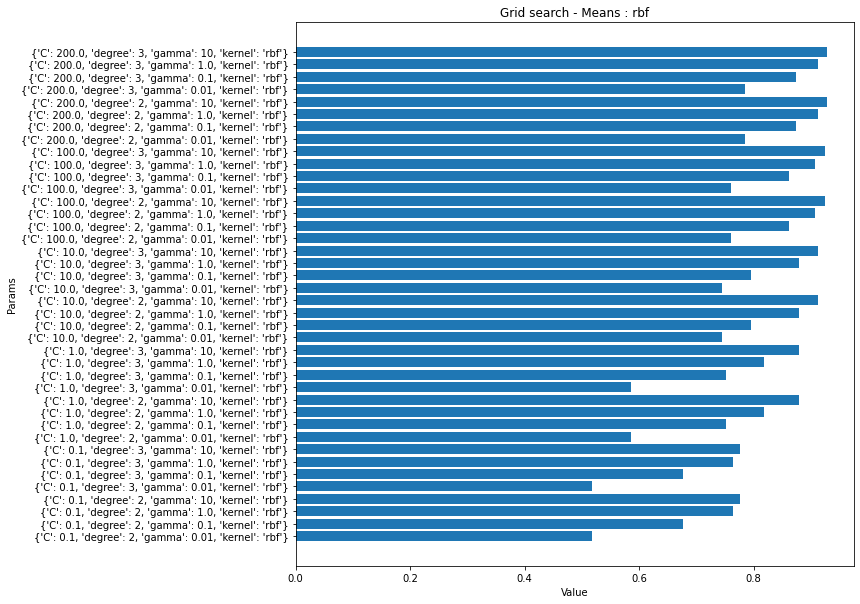

In [98]:
# plot bar
# rbf
fig = plt.figure(figsize=(10,10))
plt.barh(rbf_params_list, rbf_mean_list)
plt.title('Grid search - Means : rbf') 
plt.ylabel('Params')
plt.xlabel('Value')
plt.show()

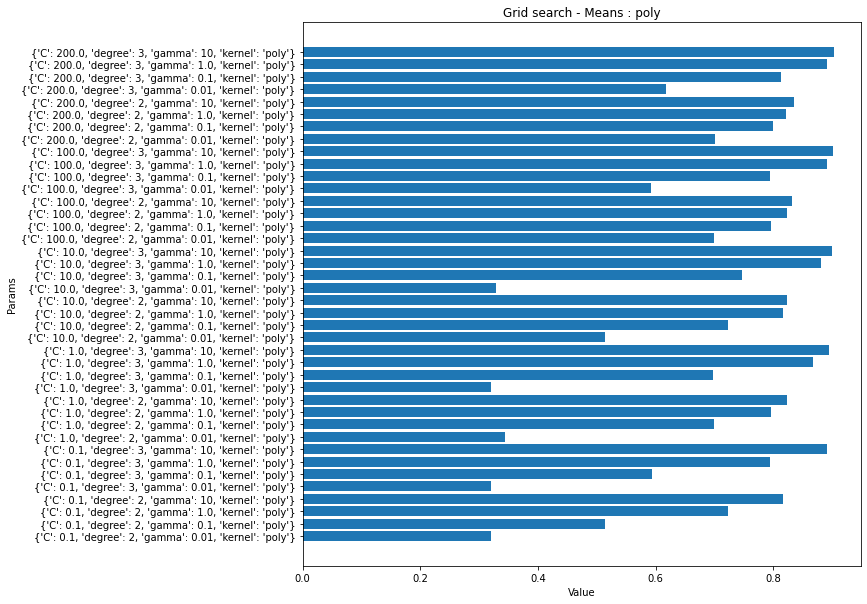

In [99]:
# plot bar
# poly
fig = plt.figure(figsize=(10,10))
plt.barh(poly_params_list, poly_mean_list)
plt.title('Grid search - Means : poly') 
plt.ylabel('Params')
plt.xlabel('Value')
plt.show()

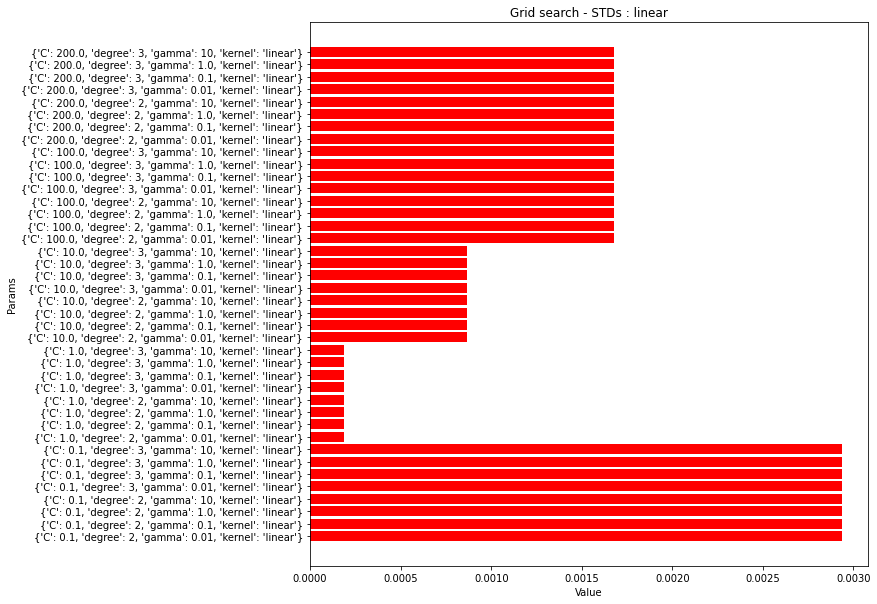

In [106]:
# plot std bar
# linear
fig = plt.figure(figsize=(10,10))
plt.barh(lin_params_list, lin_std_list, color='red')
plt.title('Grid search - STDs : linear') 
plt.ylabel('Params')
plt.xlabel('Value')
plt.show()

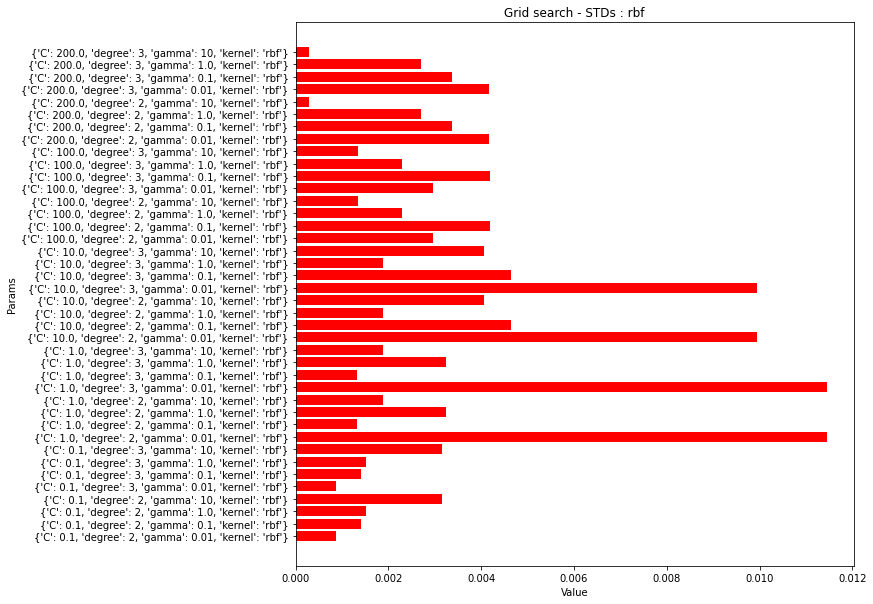

In [105]:
# plot std bar
# rbf
fig = plt.figure(figsize=(10,10))
plt.barh(rbf_params_list, rbf_std_list, color='red')
plt.title('Grid search - STDs : rbf') 
plt.ylabel('Params')
plt.xlabel('Value')
plt.show()

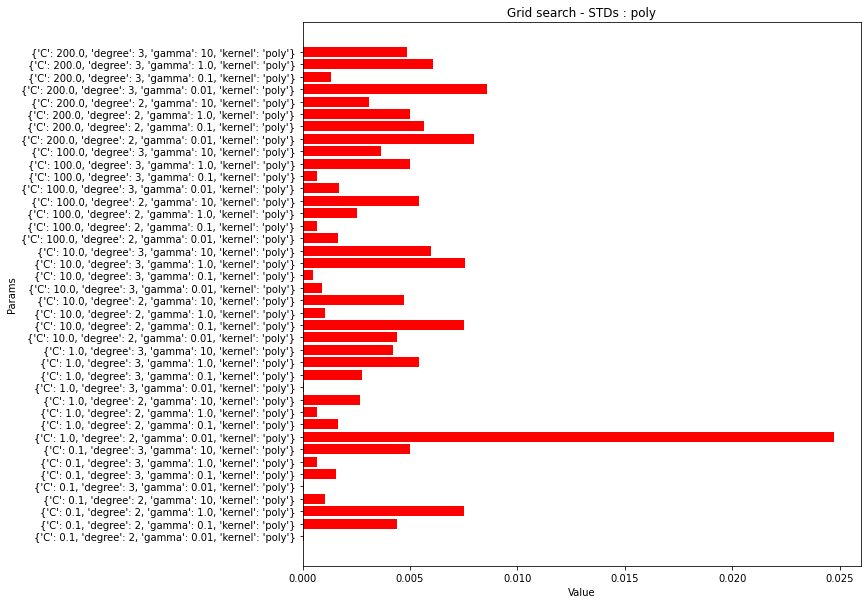

In [107]:
# plot std bar
# poly
fig = plt.figure(figsize=(10,10))
plt.barh(poly_params_list, poly_std_list, color='red')
plt.title('Grid search - STDs : poly') 
plt.ylabel('Params')
plt.xlabel('Value')
plt.show()